# RDKit: making new molecules using reactions SMARTS

This notebook explores using `RDKit` to define chemical reactions and to use these reactions to create new molecules from existing reactants. It uses RDKit's SMARTS matches.  This notebook isn't a replacment for the [rdkit documentation](http://www.rdkit.org/docs/), but is intended to complement it.

@TAGS: #basics #reactions

In [1]:
# import rdkit components
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# use IPythonConsole for pretty drawings
from rdkit.Chem.Draw import IPythonConsole

## The next line is commented out 
### because GitHub does not render svg's embedded in notebooks
IPythonConsole.ipython_useSVG=True
# IPythonConsole.ipython_useSVG=False

# for flattening tuples and lists
from itertools import chain

# Unimolecular reactions

It's easy to get a feel for how the system works with some simple examples.  Let's take the oxidation of alcohols to ketones/aldehydes.  In real life, these reactions are not really unimolecular.  The electrons and hydrogen atoms that leave during the oxidation have to go somewhere.  But in these examples we aren't tracking the fate of those atoms; we're only tracking the transformations that happen to a single structure.  That's what we mean by unimolecular.

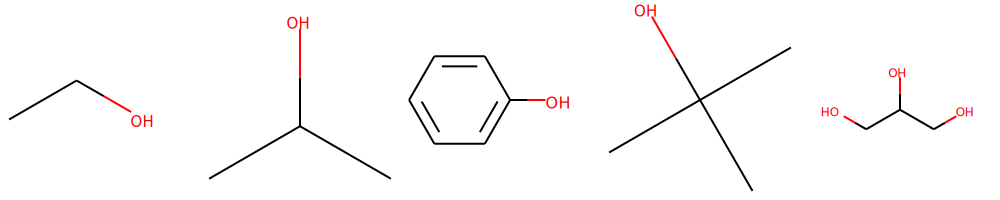

In [2]:
ethanol = Chem.MolFromSmiles('CCO')
isopropanol = Chem.MolFromSmiles('CC(C)O')
phenol = Chem.MolFromSmiles('c1cccc(O)c1')
t_butanol = Chem.MolFromSmiles('C(C)(C)(C)O')
glycerol = Chem.MolFromSmiles('OCC(O)CO')

alcohols = [ethanol, isopropanol, phenol, t_butanol, glycerol]

Draw.MolsToGridImage(alcohols, molsPerRow=5)

There are a few ways we could imagine defining the reaction.

In [3]:
rxn_1 = AllChem.ReactionFromSmarts('[#6:1]([O:2])>>[#6:1](=[O:2])')

This definition says:

  1. Take _any_ carbon atom, which we'll label as atom #1, whether aliphatic or aromatic, that ...
  2. ... is bound via a single bond to an aliphatic oxygen atom (capital O), that we label as atom #2, and
  3. transform the linkage between these atoms to be a double bond.
  
This is an OK definition, but it is going to run into problems.  Phenol doesn't oxidize to a ketone because it would entail disruption of the aromaticity of the benzene ring, and t-butanol doesn't because it would result in a pentavalent carbon.  rdkit has ways of letting us know about this, as we shall see.

First, we have to run the reaction.  Let's show it working on isopropanol.

In [4]:
rxn_1.RunReactants((isopropanol, ))

((<rdkit.Chem.rdchem.Mol at 0x11734c0c8>,),)

A couple of things to note about the input and output to the `RunReactants()` method:
  1.  The input is a Python _tuple_.  Note the extra parentheses and the trailing `,` in the input above.  This makes it easy to supply multiple reactants when reactions involve more than one molecule.
  2.  The output is a tuple of tuples.  The _inner_ tuples are there because even reactions that take only a single input molecule can result in multiple output molecules (e.g. hydrolysis).  The _outer_ tuples are there because rdkit applies your reaction incidence of the appropriate motifs in the input molecule, even if it occurs more than once.  
  
The upshot of all this is that it takes a bit of indexing to get your molecule out, it can be done.

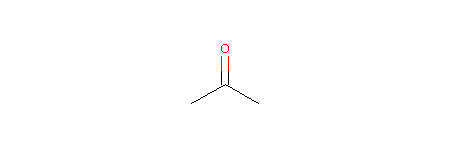

In [5]:
rxn_1.RunReactants((isopropanol, ))[0][0]

Behold!  Acetone is apparently produced.  Things worked.  Now let's try t-butanol.

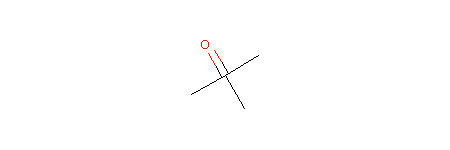

In [6]:
rxn_1.RunReactants((t_butanol, ))[0][0]

Uh-oh!  RDKit gave us a pentavalent carbon.  That can't be right.  

The reason this happens is that by default, the products of `RunReactants` are not sanitized, i.e., rdkit doesn't check to see if they make sense.  We can do that check using `Chem.SanitizeMol()`, and the results match up with chemical common sense.

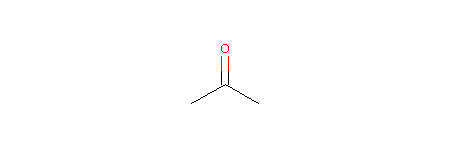

In [7]:
# acetone can be sanitized
acetone = rxn_1.RunReactants((isopropanol, ))[0][0]
Chem.SanitizeMol(acetone)
acetone

RDKit ERROR: [22:20:16] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 162 in file /Users/glandrum/anaconda/conda-bld/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [22:20:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 162 in file /Users/glandrum/anaconda/conda-bld/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [22:20:17] Explicit valence for atom # 0 C, 5, is greater than permitted


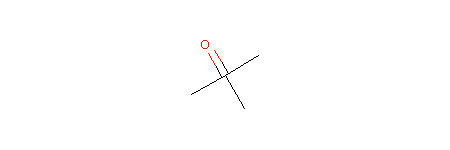

In [8]:
#doctest: IGNORE
# "t-butyl ketone" cannot be sanitized
crazy_molecule = rxn_1.RunReactants((t_butanol, ))[0][0]
try:
    Chem.SanitizeMol(crazy_molecule)
except ValueError:
    pass
crazy_molecule

The warning message is a clue that something is wonky with the "ketone" that we created with the reaction. 

Continuing on, let's see what happens with glycerol.

In [9]:
rxn_1.RunReactants((glycerol, ))

((<rdkit.Chem.rdchem.Mol at 0x1176426e0>,),
 (<rdkit.Chem.rdchem.Mol at 0x117642050>,),
 (<rdkit.Chem.rdchem.Mol at 0x117642848>,))

Now the ouput is a single-item tuple of _three_ tuples.  This means that rdkit found three places in the reactant at which it could apply the reaction rule, and each reaction created a single product.  A Pythonic way to look at all these products at once is to unpack the tuples with the `chain.from_iterable()` method from `itertools`.

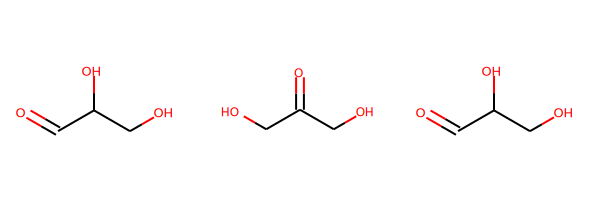

In [10]:
glycerol_products = rxn_1.RunReactants((glycerol, ))
Draw.MolsToGridImage(list(chain.from_iterable(glycerol_products)))

The output shows three molecules, because glycerol has three hydroxyl groups that can be oxidized.  rdkit does not know about the symmetry of the glycerol molecule, i.e. that oxidizing carbon 1 gives the same molecule as oxidizing carbon 3. So glyceraldehyde appears twice while dihydroxyacetone appears only once.  RDKit molecules are really pointers to locations in memory, so equating two equivalent molecules will not be equal to each other.  Doing the comparison in a simple case like this can be done by converting to SMILES.

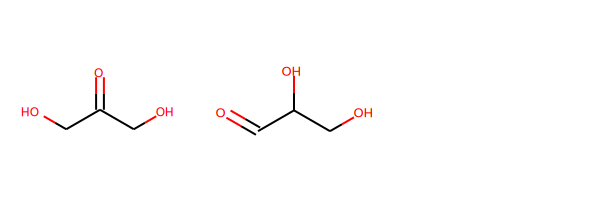

In [11]:
all_products = list(chain.from_iterable(glycerol_products))
all_product_smiles = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_products]
unique_products = [Chem.MolFromSmiles(smiles) for smiles in set(all_product_smiles)]
Draw.MolsToGridImage(unique_products)

Now we have the two unique possible products.  Phenol presents another problematic case for our reaction.

RDKit ERROR: [22:20:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 162 in file /Users/glandrum/anaconda/conda-bld/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [22:20:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 162 in file /Users/glandrum/anaconda/conda-bld/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [22:20:17] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [22:20:17] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


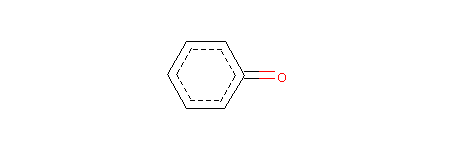

In [12]:
#doctest: IGNORE
# "phenyl ketone" cannot be kekulized
crazy_molecule = rxn_1.RunReactants((phenol, ))[0][0]
crazy_molecule


In [13]:
#doctest: IGNORE
# "phenyl ketone" cannot be kekulized, but it can be sanitized
crazy_molecule = rxn_1.RunReactants((phenol, ))[0][0]
try:
    Chem.SanitizeMol(crazy_molecule)
except ValueError:
    pass
print Chem.MolToSmiles(crazy_molecule)

O=c1ccccc1


RDKit ERROR: [22:20:17] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 


We can fix most of the problems we've experienced with a better-defined SMARTS reaction.  Here's one that will only work on aliphatic primary or secondary alcohols.

In [20]:
rxn_2 = AllChem.ReactionFromSmarts('[Ch:1]([O:2])>>[C:1](=[O:2])')

In [25]:
all_products = tuple(rxn_2.RunReactants((mol, )) for mol in alcohols)
foo = chain.from_iterable(chain.from_iterable(all_products))

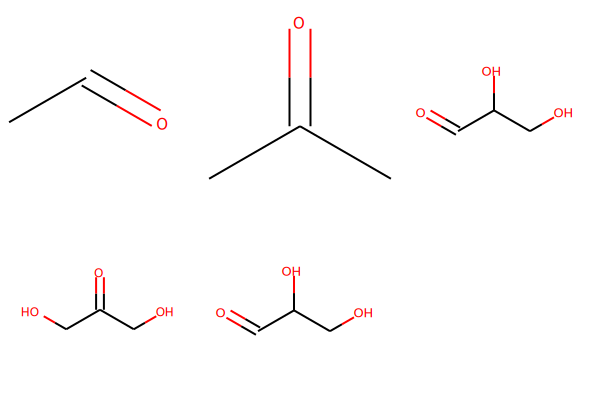

In [30]:
foo = list(chain.from_iterable(chain.from_iterable(all_products)))
Draw.MolsToGridImage(foo)

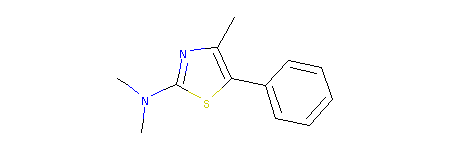

In [33]:
# Hantzsch thiazole synthesis
thiourea = Chem.MolFromSmiles('CN(C)C(=S)N')
haloketone = Chem.MolFromSmiles('c1ccccc1C(=O)C(C)Cl')
rxn_smarts = '[NH2:1][C:2](=[S:3])[NH0:4].[C:5](=[O:6])[C:7][Cl:8]>>[N:4][c:2]1[s:3][c:5][c:7][n:1]1'
rxn = AllChem.ReactionFromSmarts(rxn_smarts)
product = rxn.RunReactants((thiourea, haloketone))[0][0]
Chem.SanitizeMol(product)
product